In [1]:
import pandas, keras
import numpy as np
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks
import os 
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Using the right amount of resources

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
set_session(tf.Session(config=config))

# Exploring the dataset:

## Load the dataset files

In [3]:
particles_per_event=80
features=4
n_events=10000

store_train = pandas.HDFStore("/disk/lhcb_data/davide/ML4HEP_exercise/train.h5")
df_train = store_train.select("table",stop=n_events)

cols = [c.format(i) for i in range(particles_per_event) for c in ["E_{0}",  "PX_{0}",  "PY_{0}",  "PZ_{0}"]]
T = df_train[cols].values[0:n_events].reshape(n_events,particles_per_event,features)

## The dataset tensor
Our dataset is organized in a rank 3 tensor T, whose elements are labeled by indices (i, j, k). Index i runs on the event number, j numbers the particles in each event and index k the variable associated to the track in the event

$$
T = (i=1,...,n_{events}, j=1,...,\textit{particles per event}, k= E_{j} , PX_{j}, PY_{j}, PZ_{j})
$$


In [4]:
T.shape

(10000, 80, 4)

## Fancy indexing

For example, we can access to the single particles four momentum in an event by making use of indexing. Let's take the first particle in the first event: 

In [5]:
print('The first particle in the first event has the following four momentum \n')
print('E_0 = {0:.5g}'.format(T[0,0,0]))
print('PX_0 = {0:.5g}'.format(T[0,0,1]))
print('PY_0 = {0:.5g}'.format(T[0,0,2]))
print('PZ_0 = {0:.5g}'.format(T[0,0,3]))

The first particle in the first event has the following four momentum 

E_0 = 474.07
PX_0 = -250.35
PY_0 = -223.65
PZ_0 = -334.74


The same information can be accessed using numpy fancy indexing syntax, for example

In [6]:
print('The first particle in the first event has the following four momentum \n')
print(T[0,0,:])

The first particle in the first event has the following four momentum 

[ 474.07114 -250.34703 -223.65196 -334.7381 ]


**Exercise**:Now, using numpy array methods calculate:

1) the mean energy of all particles over all events (hint: exclude from the mean the empty events)


2) the mean energy of the first 5 particles for the first 10 events

3) the maximum PZ (in modulus) of the dataset

In [7]:
#Solution:

#1) T[:,:,0][np.where(T[:,:,0]!=0)].mean()
#2) T[0:10,0:5,0].mean()
#3) np.abs(T[:,:,3]).max()

# Variables at hadron colliders: kinematic invariants


The dataset can be cast to the $(\eta \text{, } \phi)$ space.
The rapidity $\eta$ is related to $PZ$, of the particle track. It is defined as:

$$
\eta = - \frac{1}{2} ln \left(\frac{E - PZ}{ E + PZ} \right)
$$

While $\phi$ is related to the $(PX, PY)$ components by:

$$
\phi = arctg\left( \frac{PY}{PX} \right)
$$

As shown in figure, the CMS detector is formed by:

1) a cylindrical barrel detector placed around the interaction point that covers a rapidity range of $|\eta| < 2.5 $

2) two $1.48 < | \eta | < 3.0$ endcap regions

<tr>
<td><img src="imgs/front.png" style="width:500px;height:400px;">
<td><img src="imgs/side.png" style="width:500px;height:400px;">
<tr>


<caption><u><font color='purple'>**Figure**</u><font color='purple'>Need a caption here<br> <font color='black'>

The four momentum of each particle can be represented in the coordinates $(E, \phi, \eta)$ and each event can be displayed as 2D image in the ($\phi, \eta$) coordinates, whose pixels values are the corresponding E recorded by the calorimeter.

First can convert the dataset to this new set of variables. We can do it with a few lines of code thanks to indexing:

In [21]:
eta=np.where(T[:,:,0]==0, 0, 0.5*np.log((T[:,:,0]-T[:,:,3])/(T[:,:,0]+T[:,:,3])))
phi=np.where(T[:,:,0]==0, 0, np.arctan(T[:,:,2]/T[:,:,1]))
E=T[:,:,0]

/home/hep/davide/miniconda3/envs/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/hep/davide/miniconda3/envs/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/hep/davide/miniconda3/envs/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/hep/davide/miniconda3/envs/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Then we can check that the $\phi$ angular coverage is of $\pi$

In [27]:
phi_range=np.abs(phi.min())+phi.max()
print(phi_range)

3.1415784


And that the rapidity range is within the expected one

In [28]:
eta_range=np.abs(eta.min())+eta.max()
eta.min(), eta.max()

(-2.7575567, 2.7707026)

In [29]:
eta_rescaled=(eta+np.abs(eta.min()))/eta_range*40
phi_rescaled=(phi+np.abs(phi.min()))/phi_range*40

batch_size=2000
n_batches=n_events//batch_size
phi_pixels=40
eta_pixels=40

pics_dict={}

for i in range(n_batches):
    
    pic = np.zeros(shape=(phi_pixels,eta_pixels,1),dtype=np.float32)
    pics_dict[i]=np.array([pic for j in range(0,batch_size)])
        #pics_dict_flip[n]=np.array([pic for i in range(0,batch_size)])

    for event in range(batch_size):

        for n_track in range((phi[event]>0).sum()):
            #print(n_track)
            phi_coord = int(np.floor(phi_rescaled[event][n_track]))
            eta_coord = int(np.floor(eta_rescaled[event][n_track]))
        
            #if 0<phi_coord<phi_pixels:
                #if 0<eta_coord<eta_pixels:
                
            pics_dict[i][event][phi_coord,eta_coord]=E[event][n_track]

In [30]:
batch_number=0
event_display=100

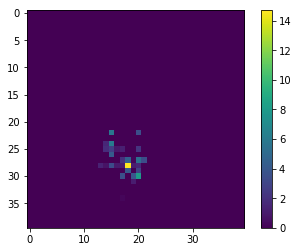

In [31]:
plt.imshow(pics_dict[batch_number][event_display].reshape(40,40))
plt.colorbar()

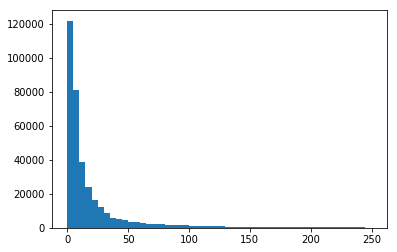

In [32]:
plt.hist(E[np.where(2<E)],range=(0,250),bins=50);

# Building the neural network

In [5]:
# Define the network
model = keras.models.Sequential()
model.add(keras.layers.Dense(2, input_shape = (80,), activation='softmax'))

# Train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
model.fit(df_train[cols].as_matrix(), keras.utils.to_categorical(df_train["is_signal_new"]), epochs=10)

/home/hep/davide/miniconda3/envs/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Epoch 1/10
10000/10000 [==============================] - 1s 86us/step - loss: 6.2116 - acc: 0.5445
Epoch 2/10
10000/10000 [==============================] - 1s 55us/step - loss: 4.1712 - acc: 0.6148
Epoch 3/10
10000/10000 [==============================] - 1s 54us/step - loss: 3.4288 - acc: 0.6232
Epoch 4/10
10000/10000 [==============================] - 1s 56us/step - loss: 2.5045 - acc: 0.6176
Epoch 5/10
10000/10000 [==============================] - 1s 56us/step - loss: 1.7089 - acc: 0.6175
Epoch 6/10
10000/10000 [==============================] - 1s 55us/step - loss: 1.2610 - acc: 0.6204
Epoch 7/10
10000/10000 [==============================] - 1s 54us/step - loss: 0.9665 - acc: 0.6266
Epoch 8/10
10000/10000 [==============================] - 1s 55us/step - loss: 0.8228 - acc: 0.6327
Epoch 9/10
10000/10000 [==============================] - 1s 55us/step - loss: 0.7668 - acc: 0.6326
Epoch 10/10
10000/10000 [==============================] - 1s 55us/step - loss: 0.7159 - acc: 0.6381

# Neural network optimization

In [4]:
### Evaluate performance on independent sample
# DO NOT CHANGE BELOW!

# Prepare input
store_test = pandas.HDFStore("test_without_truth_100k.h5")
df_test = store_test.select("table")

# Run DNN
print("Running on full test sample. This may take a moment.")
ret = model.predict(df_test[cols].as_matrix())
np.save("result.npy",ret[:,1])
!zip result.zip result.npy
print("Done. Click below  to download result")
FileLink('result.zip')

Running on full test sample. This may take a moment.
updating: result.npy (deflated 10%)
Done. Click below  to download result


/home/ubuntu/challenge/result.zip